## Get data

In [1]:
import pandas as pd
import warnings
from utils.mt_5.data import get_currency_pair_data_

warnings.filterwarnings('ignore')

symbol = "USDCAD"  

df = get_currency_pair_data_(symbol, timeframe="M30", years_back=.08)
df

,close
time,
2024-10-24 11:30:00,1.38147
2024-10-24 12:00:00,1.38148
2024-10-24 12:30:00,1.38178
2024-10-24 13:00:00,1.38135
2024-10-24 13:30:00,1.38166
...,...
2024-12-04 15:00:00,1.40616
2024-12-04 15:30:00,1.40645
2024-12-04 16:00:00,1.40608


## Model trend

In [2]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

dp = DeterministicProcess(index=df.index, order=1, constant=True, drop=True)

X = dp.in_sample()
y = df['close']

y, X = y.align(X, join='inner')

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

time
2024-10-24 11:30:00    1.386611
2024-10-24 12:00:00    1.386625
2024-10-24 12:30:00    1.386639
2024-10-24 13:00:00    1.386653
2024-10-24 13:30:00    1.386667
                         ...   
2024-12-04 15:00:00    1.406107
2024-12-04 15:30:00    1.406121
2024-12-04 16:00:00    1.406135
2024-12-04 16:30:00    1.406149
2024-12-04 17:00:00    1.406163
Length: 1402, dtype: float64

<Axes: xlabel='time'>

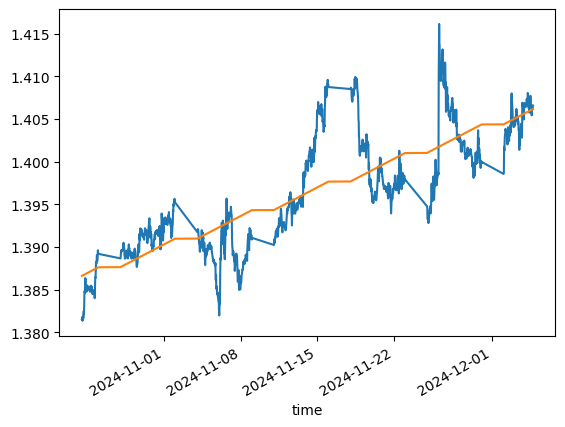

In [3]:
df['close'].plot()
y_pred.plot()

## Forecast

In [4]:
X_ = dp.out_of_sample(14)
X_dates = pd.date_range(start=X.index[-1], periods=len(X_), freq=pd.Timedelta(minutes=30))

y_fore = pd.Series(model.predict(X_), index=X_.index)

forecast_df = pd.DataFrame(y_fore)
forecast_df.index = X_dates

forecast_df.columns = ['predicted_close']
forecast_df

,predicted_close
2024-12-04 17:00:00,1.406177
2024-12-04 17:30:00,1.406191
2024-12-04 18:00:00,1.406205
2024-12-04 18:30:00,1.406219
2024-12-04 19:00:00,1.406233
2024-12-04 19:30:00,1.406247
2024-12-04 20:00:00,1.406261
2024-12-04 20:30:00,1.406275
2024-12-04 21:00:00,1.406289
2024-12-04 21:30:00,1.406303


In [5]:
current_price = df['close'].iloc[-1] 
predicted_day_close = round(forecast_df['predicted_close'].iloc[-1], 5) 

threshold = 0.001  

if predicted_day_close > current_price: # buy
    print("predicted_day_close is GREATER than current_close")
    target_profit = round((predicted_day_close - current_price) * 10000)

if predicted_day_close < current_price: # short-sell
    print("We will close LOWER!")
    target_profit = round((current_price - predicted_day_close) * 10000)
    


print(current_price, predicted_day_close, target_profit)

We will close LOWER!
1.4066 1.40636 2


## Trade

In [6]:
from utils.mt_5.trade import buy, short_sell, sell

current_price = df['close'].iloc[-1] 
predicted_day_close = round(forecast_df['predicted_close'].iloc[-1], 5)  

past_1800hrs = df.index.time[-1] >= pd.Timestamp('20:00:00').time()

if not past_1800hrs:
    if predicted_day_close > current_price: # buy
        print("predicted_day_close is GREATER than current_close\n\n....BUYING....\n")
        target_profit = round((predicted_day_close - current_price) * 10000)
        buy(symbol, target_profit=target_profit)

    elif predicted_day_close < current_price: # short-sell
        print("We will close LOWER!\n\n.....SHORT-SELLING.....\n")
        target_profit = round((current_price - predicted_day_close) * 10000)
        short_sell(symbol, target_profit=target_profit)
    else:
        print("....I DON'T KNOW HOW TO HELP YOU!....")
else: # sell
    print("You CANNOT trade PAST 1800hrs\n\n....SELLING....\n")
    sell(symbol)


We will close LOWER!

.....SHORT-SELLING.....

Cannot short sell USDCADm of 0.01 lots at 1.4066 because of 'No money'
